In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from imblearn.over_sampling import SMOTENC
import seaborn as sb

In [3]:
df = pd.read_csv("../Oblig2/winequality-red.csv", delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Hensikten med datasettet er å muliggjøre analyse og modellering av vin kvalitet ut ifra forskjellige målte kjemiske karaterestikker (features) som for eks. «fixed acidity», «citric acid», "alcohol" osv.
Datasettet inneholder en target kolonne, «quality». Kolonnen oppgir en vurdering av kvaliteten til en vin og skal være oppgitt med en int-verdi fra 1-10 [1].
Videre inneholder datasettet 11 kolonner med feature verdier som beskrive forskjellige målte kjemiske egenskaper den enkelte vinen har. Alle disse kolonnen har en verditype av float.

ref [1]: UCI Irvine. (u.å). Wine Quality. Hentet 12.10.2025 fra "https://archive.ics.uci.edu/dataset/186/wine+quality"

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Ut i fra seksjonene over så ser det ikke ut til at det er noen manglende verdier i datasettet.

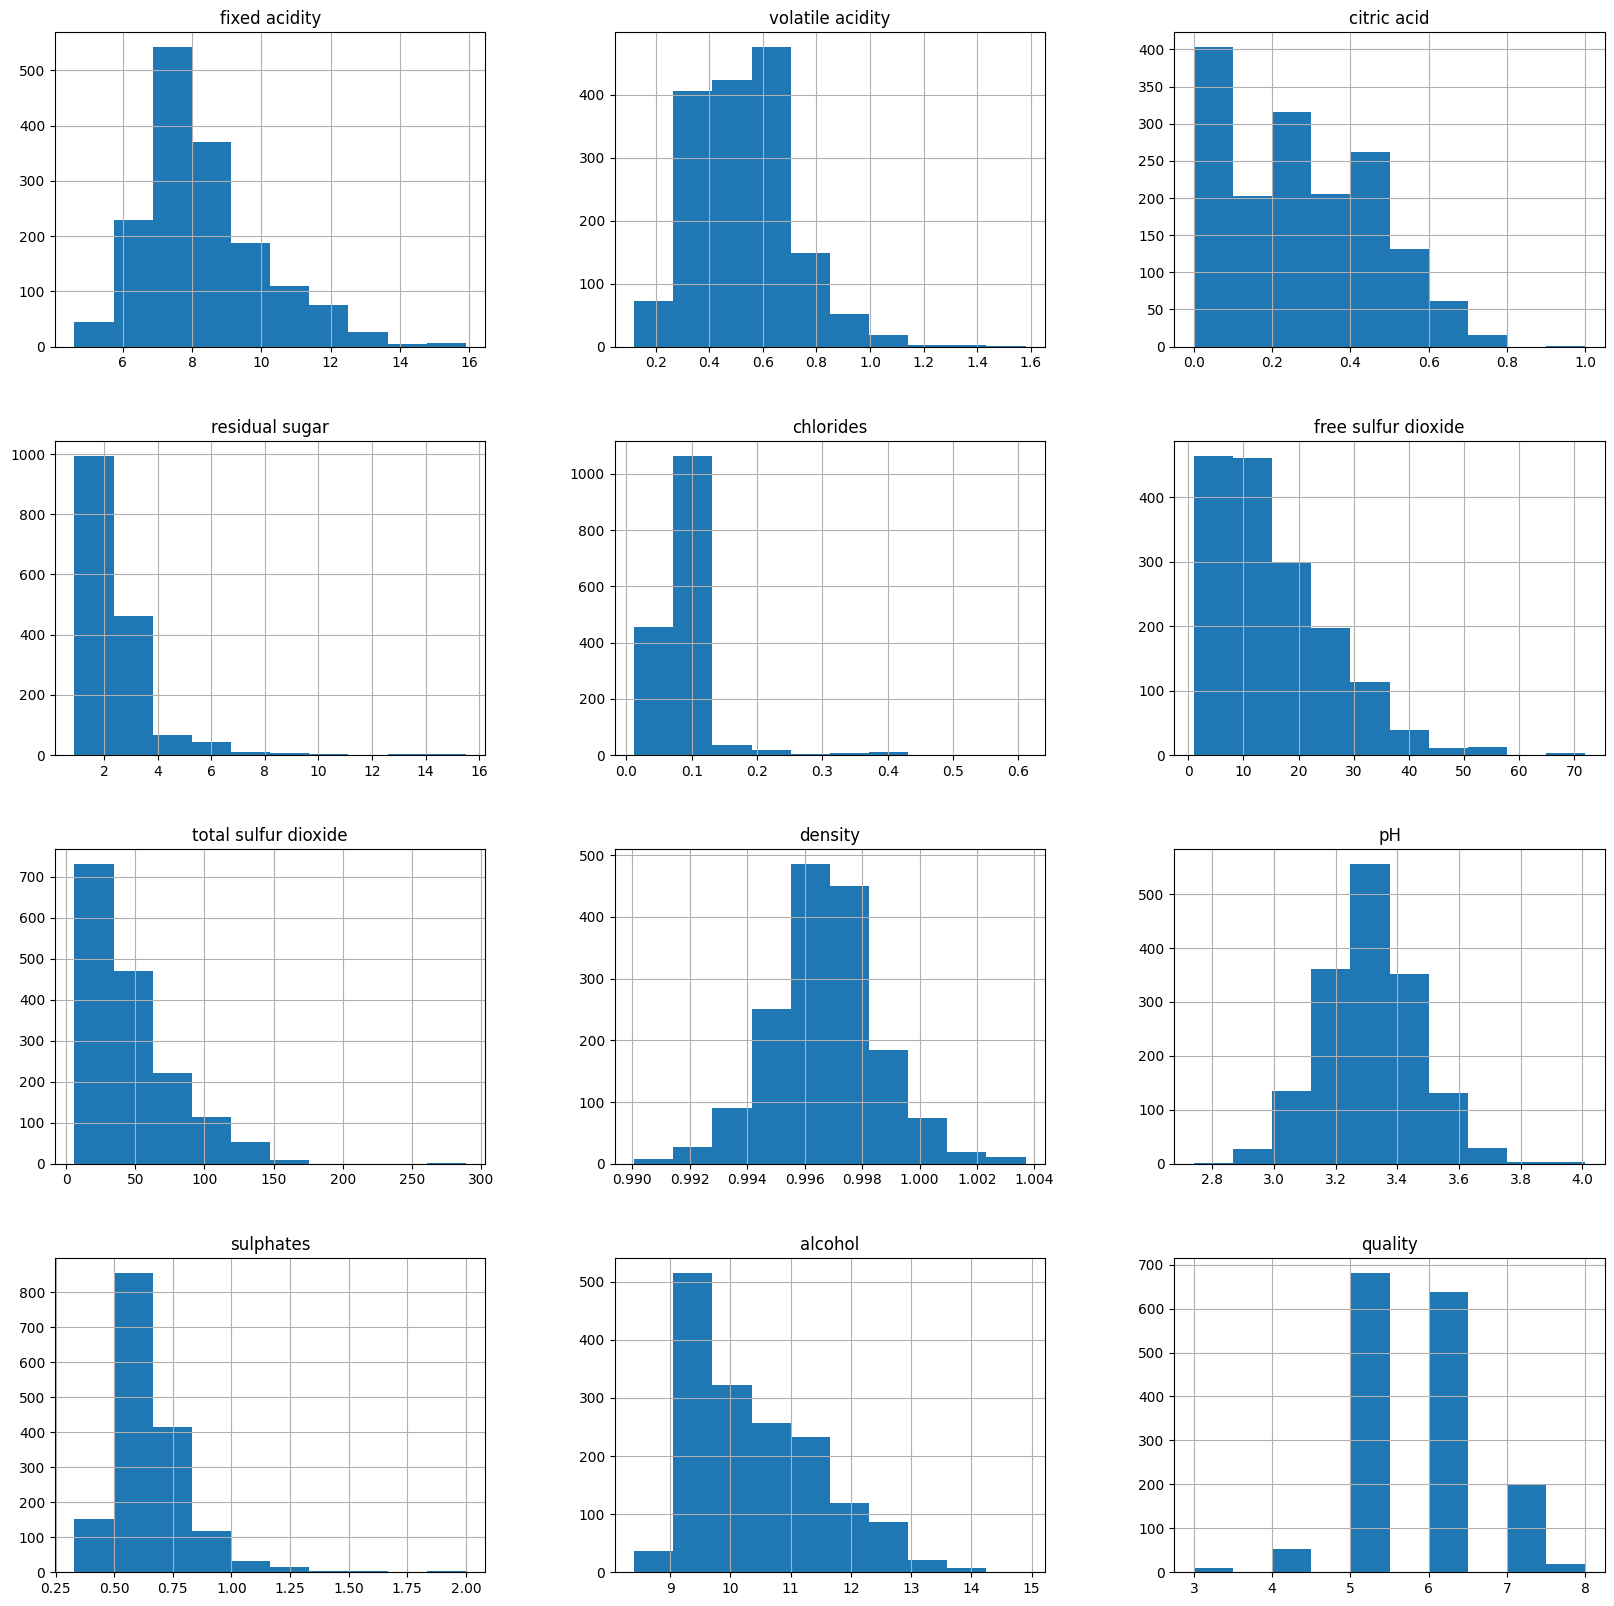

In [6]:
df.hist(figsize=(20,20))
plt.show()

Som vi ser ut i fra histogrammene i seksjonen over så ser datasettet i hovedsak ser ut til å være relativt normalfordelt eller ensidig normalfordelt. Det er imidlertid en betydelig forskjell i scaleringen til verdiene til de forskjellige featurene og det er dermed sansynelig at vi bør gjøre en vurdering i forhold scalering ved analysen av datasettet. 

I seksjonene under har jeg gjennomført en test scalering med MinMaxScaler, som vi ser ut i fra histogrammet etter denne scaleringen så x-verdiene nå fordelt i samme range mellom 0-1.

I den videre koden kommer jeg til å legge inn alternativ for scalering med både MinMaxScaler og StandardScaler, slik at begge disse kan testes ut ved trening av modelen.

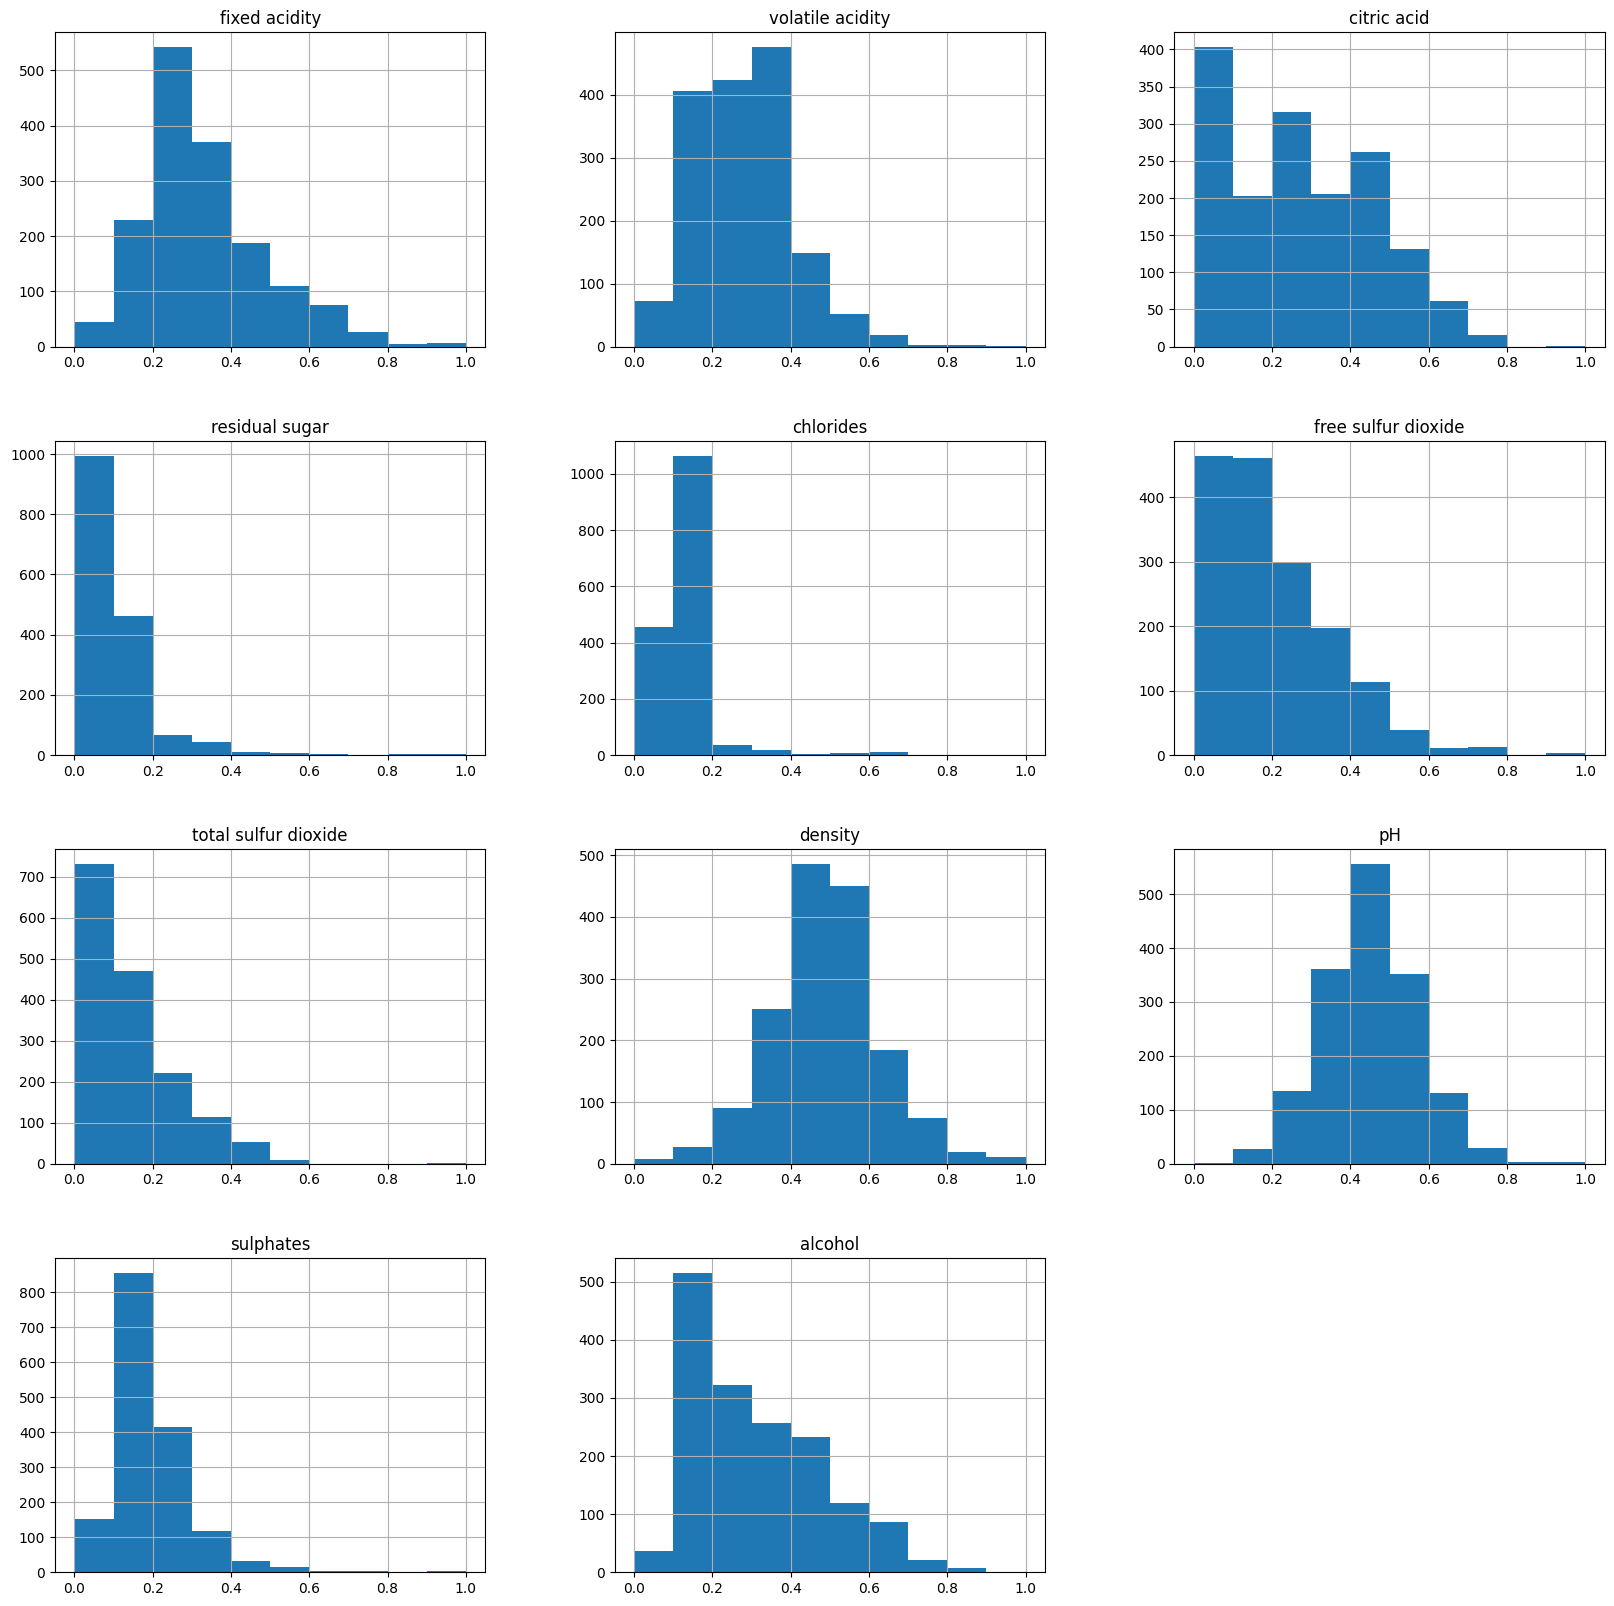

In [21]:
test_scaler = MinMaxScaler()
df_test_scaler = df.drop(columns='quality', axis=1)
test_scaler.fit(df_test_scaler)
df_test = pd.DataFrame(test_scaler.transform(df_test_scaler), columns=df_test_scaler.columns)
df_test.hist(figsize=(20,20))
plt.show()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


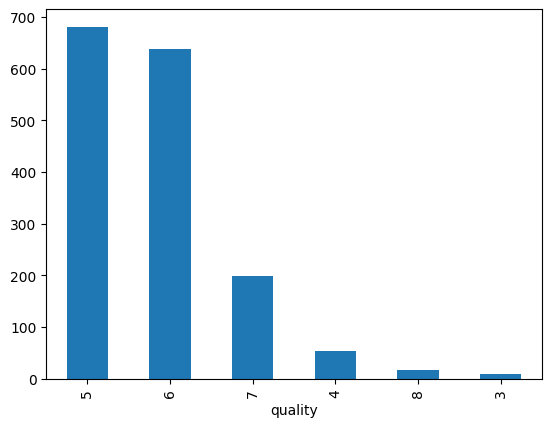

In [7]:
df['quality'].value_counts().plot.bar()
print(df['quality'].value_counts())

Basert på dataene i seksjonen over så ser vi tydelig at datasette har en betydelig skjevfordeling i target verdiene og at det er en over representasjon for verdier på 5 og 6 i 'quality' kolonnen, mens det er veldig få verdier registrert for 8 og 3. Dermed er bør vi vudere å gjennomføre videre behandling av datasettet med uppsampling eller downsampling. Ut i fra forskjellen i fordeling så vil det kunne være gunstig å bruke en kombinasjon av disse, da det veldig stor forskjell mellom fordelingen av verdiene og det er ikke gunstig å lage for mye syntetisk data basert på få verdier.

Videre vil det også være hensiktsmessig å gjøre eventuell upsamling etter oppdeling av datasettet i traning, validation og test, slik at du redusere sansynligheten for helhetlig overfiting siden du kun da lager systetisk data basert på de idividuelle oppdelingene.

Vi ser også at det vil være hensiktsmessig å bruke stratified sampling til oppdeling av datasettet slik at vi sikrer en tilstrekklig fordeling av de underreprenterte verdiene for 'quality' kolonnen før evntuell videre behandling.

Det vil også være nødvendig å transformere 'quality' kolonnen til en kategorisk datatype slik av vi kan bruke SMOTENC til genereringen av de sytestiske datene.

I seksjonen nedenfor gjør jeg en enkel demonstrasjon av upsampling med SMOTENC, som vi ser av resultatet så lager SMOTENC da sytetiske verdier slik at hele datasettet blir balansert. Det er imidlertid ikke nødvendigvis lurt å lage så mange syntetsiske verdier som må dette tilfellet. I selv implementasjoen kommer jeg derfor til først å gjøre en downsampling slik at vi ikke må lage like mange syntetiskeverdier og at dette blir gjort i loopingen som jeg brygger opp for teste modelene, slik at oppdeling her blir en del av randomiseringen ved oppdeling av datasettet. 

In [8]:
df['quality'] = df['quality'].astype('category')

quality
3    681
4    681
5    681
6    681
7    681
8    681
Name: count, dtype: int64


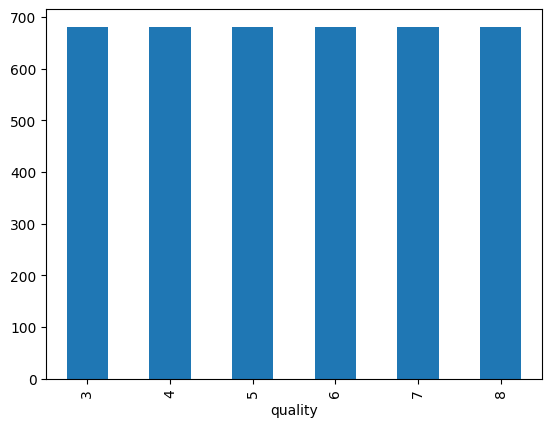

In [22]:
df_oversampled, _ = SMOTENC('auto').fit_resample(df, df['quality'])
df_oversampled['quality'].value_counts().plot.bar()
print(df_oversampled['quality'].value_counts())

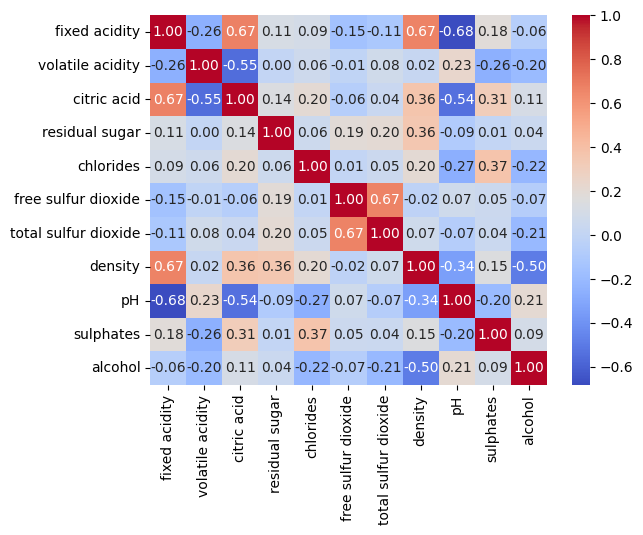

In [9]:
df_features = df.drop(columns='quality', axis=1)
matrix = df_features.corr()
sb.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Som vi ser av heatmapen over så er det ingen korrelasjoner som er sterkere en 0.70 eller -0.70 og fleste parten av feature settene har velig liten korrelasjon, så jeg velger derfor ikke å gjøre noen videre analyse og behandling av datasette med principal component analysisk (pca) i forhold til dette. 

In [38]:
# funksjon for splitting av dataset, og downsampling for balanser
def split_dataset(data, down_s=0):    
    
    if(down_s > 0): data = downsampling(data, down_s)

    train_val = data.groupby("quality", observed=False, group_keys=False)[data.columns].sample(frac=0.8)
    test = data.drop(train_val.index)
    train = train_val.groupby("quality", observed=False, group_keys=False)[train_val.columns].sample(frac=0.75)
    validation = train_val.drop(train.index)
        
    return [train, validation, test]

def check_split_dataset(data):
    print(data[0]["quality"].value_counts()/data[0].shape[0])
    print(data[1]["quality"].value_counts()/data[1].shape[0])
    print(data[2]["quality"].value_counts()/data[2].shape[0])

def downsampling(data, n):
    df_3 = df[df['quality'] == 3]
    if(df_3['quality'].count() > n): df_3 = df_3.sample(n)

    df_4 = df[df['quality'] == 4]
    if(df_4['quality'].count() > n): df_4 = df_4.sample(n)

    df_5 = df[df['quality'] == 5]
    if(df_5['quality'].count() > n): df_5 = df_5.sample(n)

    df_6 = df[df['quality'] == 6]
    if(df_6['quality'].count() > n): df_6 = df_6.sample(n)

    df_7 = df[df['quality'] == 7]
    if(df_7['quality'].count() > n): df_7 = df_7.sample(n)

    df_8 = df[df['quality'] == 8]
    if(df_8['quality'].count() > n): df_8 = df_8.sample(n)
    
    df_down = pd.concat([df_3, df_4, df_5, df_6 , df_7, df_8])

    return df_down

def split_targets_and_features(data):
    targets = data.quality
    features = data.drop("quality", axis=1)

    return [features, targets]

def create_set_of_targets_and_features(data, min_max=False, mean=False):
    train = split_targets_and_features(data[0])
    validation = split_targets_and_features(data[1])
    test = split_targets_and_features(data[2])

    #funksjon for min_max normalisering av data
    if(min_max):
        scaler_min_max =MinMaxScaler()
        scaler_min_max.fit(train[0])
        train[0] = pd.DataFrame(scaler_min_max.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_min_max.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_min_max.transform(test[0]), columns=test[0].columns)    
    
    # funksjon for mean normalisering av data
    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(train[0])
        train[0] = pd.DataFrame(scaler_mean.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_mean.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_mean.transform(test[0]), columns=test[0].columns)

    return [train, validation, test]

# hovedfunksjon for splitting av dataset med valgmulighet for normalisering
def create_full_dataset(input, min_max=False, mean=False):
    data = split_dataset(input)
    dataset = create_set_of_targets_and_features(data, min_max, mean)

    return dataset

In [11]:
def evaluate_model_external(true_labels, pred_labels):
    adjusted_rand = adjusted_rand_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels) 
    v_measure = v_measure_score(true_labels, pred_labels)

    return [adjusted_rand, homogeneity, completeness, v_measure]

def external_results_print(adjusted_rand, homogeneity, completeness, v_measure):
    print(f'Adjusted rand score: {np.mean(adjusted_rand):.2f} +- {np.std(adjusted_rand):.2f}')
    print(f'Homogeneity score: {np.mean(homogeneity):.2f} +- {np.std(homogeneity):.2f}')
    print(f'Completness score: {np.mean(completeness):.2f} +- {np.std(completeness):.2f}')
    print(f'V-measure score: {np.mean(v_measure):.2f} +- {np.std(v_measure):.2f}')

def evaluate_model_internal(data_features, pred_labels):
    silhouette = silhouette_score(data_features, pred_labels)
    davies = davies_bouldin_score(data_features, pred_labels)
    
    return [silhouette, davies]

def internal_results_print(silhouette, davies):
    print(f'Silhouette score: {np.mean(silhouette):.2f} +- {np.std(silhouette):.2f}')
    print(f'Davies score: {np.mean(davies):.2f} +- {np.std(davies):.2f}')

def append_values(results_external, results_internal, adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies):
        adjusted_rand.append(results_external[0])
        homogeneity.append(results_external[1])
        completeness.append(results_external[2])
        v_measure.append(results_external[3])
        silhouette.append(results_internal[0])
        davies.append(results_internal[1])

def validate_kmeans(classifier, runs, test=False, min_max=False, mean=False):
    train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure, train_silhouette, train_davies = [], [], [], [], [], []
    validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure, validate_silhouette, validate_davies = [], [], [], [], [], []
    test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure, test_silhouette, test_davies = [], [], [], [], [], []

    if(runs < 1): runs = 1

    for i in range(0, runs, 1):
        dataset = create_full_dataset(df)
        model = classifier.fit(dataset[0][0])
        pred_train = model.labels_
        pred_validate = model.predict(dataset[1][0])
        pred_test = model.predict(dataset[2][0])

        r_train_external = evaluate_model_external(dataset[0][1], pred_train)
        r_train_internal = evaluate_model_internal(dataset[0][0], pred_train)
        append_values(r_train_external, r_train_internal, train_adjusted_rand, train_homogeneity, train_completeness, 
                      train_v_measure, train_silhouette, train_davies)
        
        r_validate_external = evaluate_model_external(dataset[1][1], pred_validate)
        r_validate_internal = evaluate_model_internal(dataset[1][0], pred_validate)
        append_values(r_validate_external, r_validate_internal, validate_adjusted_rand, validate_homogeneity, validate_completeness, 
                      validate_v_measure, validate_silhouette, validate_davies)
        
        if(test):
            r_test_external = evaluate_model_external(dataset[2][1], pred_test)
            r_test_internal = evaluate_model_internal(dataset[2][0], pred_test)
            append_values(r_test_external, r_test_internal, test_adjusted_rand, test_homogeneity, test_completeness, 
                      test_v_measure, test_silhouette, test_davies)

    print('Traning ressults:')
    print('**********************************')
    print('External:')
    external_results_print(train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure)
    print('**********************************')
    print("Internal:")
    internal_results_print(train_silhouette, train_davies)
    print('')
    print('Validation results:')
    print('**********************************')
    print('External:')
    external_results_print(validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure)
    print('**********************************')
    print('Internal:')
    internal_results_print(validate_silhouette, validate_davies)
    if(test):
        print('')
        print('Test results:')
        print('**********************************')
        print('External:')
        external_results_print(test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure)
        print('**********************************')
        print('Internal:')
        internal_results_print(test_silhouette, test_davies)

def validate_agglomerative(classifier, min_max=False, mean=False):
    adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies = [], [], [], [], [], []
    dataset = split_targets_and_features(df)

    if(min_max):
        scaler_min_max = MinMaxScaler()
        scaler_min_max.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_min_max.transform(dataset[0]), columns=dataset[0].columns)

    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_mean.transform(dataset[0]), columns=dataset[0].columns)

    model = classifier.fit(dataset[0])
    pred_labels = model.labels_    

    r_external = evaluate_model_external(dataset[1], pred_labels)
    r_internal = evaluate_model_internal(dataset[0], pred_labels)
    append_values(r_external, r_internal, adjusted_rand, homogeneity, completeness, 
                      v_measure, silhouette, davies)

    print('Ressults:')
    print('**********************************')
    print('External:')
    external_results_print(adjusted_rand, homogeneity, completeness, v_measure)
    print('**********************************')
    print("Internal:")
    internal_results_print(silhouette, davies)

def optimise_clusters(data, max_cluster):
    silhouette = []
    inertias = []
    n_clusters = range(2, max_cluster)
    data_features = data.drop(columns='quality', axis=1)
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data_features)

        inertias.append(kmeans.inertia_)
        silhouette.append(silhouette_score(data_features, kmeans.predict(data_features)))
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(n_clusters, inertias, "o-")
    ax[1].plot(n_clusters, silhouette, "o-")




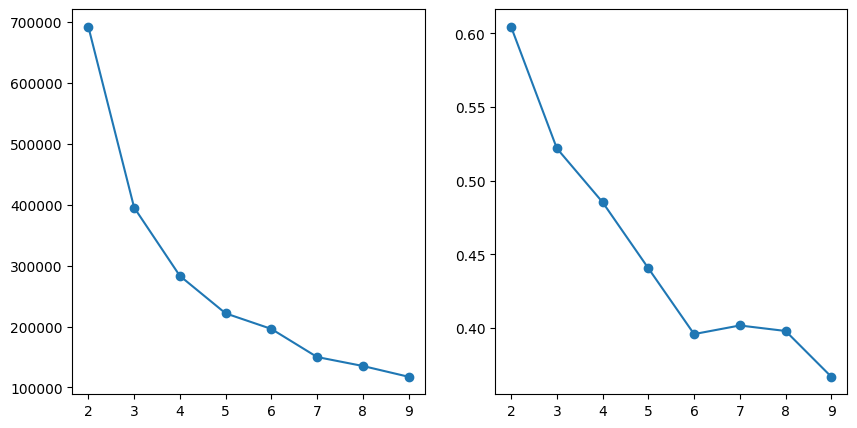

In [12]:
optimise_clusters(df, 10)

In [ ]:
for i in range(len(df.columns)-1):
    for j in range(i+1, len(df.columns)-1):
        x_label = df.columns[i]
        y_label = df.columns[j]
        sb.scatterplot(x=x_label, y=y_label, data=df, hue=df.quality)
        plt.show()

<bound method Series.count of 1299    3
899     3
832     3
690     3
1505    3
       ..
440     8
1403    8
455     8
588     8
267     8
Name: quality, Length: 136, dtype: category
Categories (6, int64): [3, 4, 5, 6, 7, 8]>


In [ ]:
df_oversampled, _ = SMOTENC('auto').fit_resample(df, df['quality'])

In [16]:
print(df_oversampled)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          7.400000          0.700000     0.000000        1.900000   0.076000   
1          7.800000          0.880000     0.000000        2.600000   0.098000   
2          7.800000          0.760000     0.040000        2.300000   0.092000   
3         11.200000          0.280000     0.560000        1.900000   0.075000   
4          7.400000          0.700000     0.000000        1.900000   0.076000   
...             ...               ...          ...             ...        ...   
4081       8.252879          0.380068     0.400339        1.800000   0.072495   
4082       8.216977          0.503019     0.382264        2.315097   0.074679   
4083       8.938353          0.469540     0.410460        2.537084   0.073775   
4084      10.911315          0.610854     0.632275        4.891339   0.084857   
4085       9.864328          0.336305     0.499042        1.989564   0.073052   

      free sulfur dioxide  

In [17]:
agg = AgglomerativeClustering(n_clusters=5)
validate_agglomerative(agg, False, True)

Ressults:
**********************************
External:
Adjusted rand score: 0.06 +- 0.00
Homogeneity score: 0.09 +- 0.00
Completness score: 0.08 +- 0.00
V-measure score: 0.08 +- 0.00
**********************************
Internal:
Silhouette score: 0.15 +- 0.00
Davies score: 1.56 +- 0.00


husk å sjekk om det er hensiktsmessig å upsample????

all data ser ut til å være normalfordel eller en sidig normalfordelt

Hensiktsmessig med normalisering pga. stor forskjellig x verdier
valg å bruke.....
som vi ser av resutlat så er----

husk å kjør enkel sammenlignings test......